In [79]:
from datetime import date, datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import cv
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

/tmp/ipython-input-2768950989.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(x="observation_date", y="IR", data=df_present, palette='viridis')


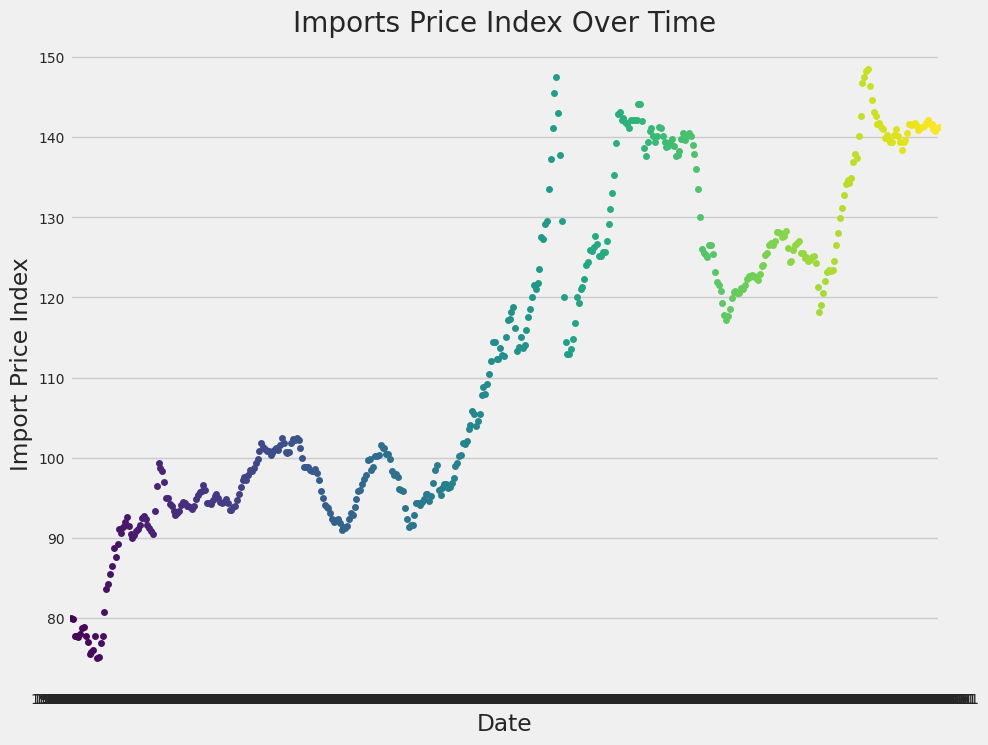

<Axes: title={'center': 'Training Data 90-10 Split'}, xlabel='observation_date'>

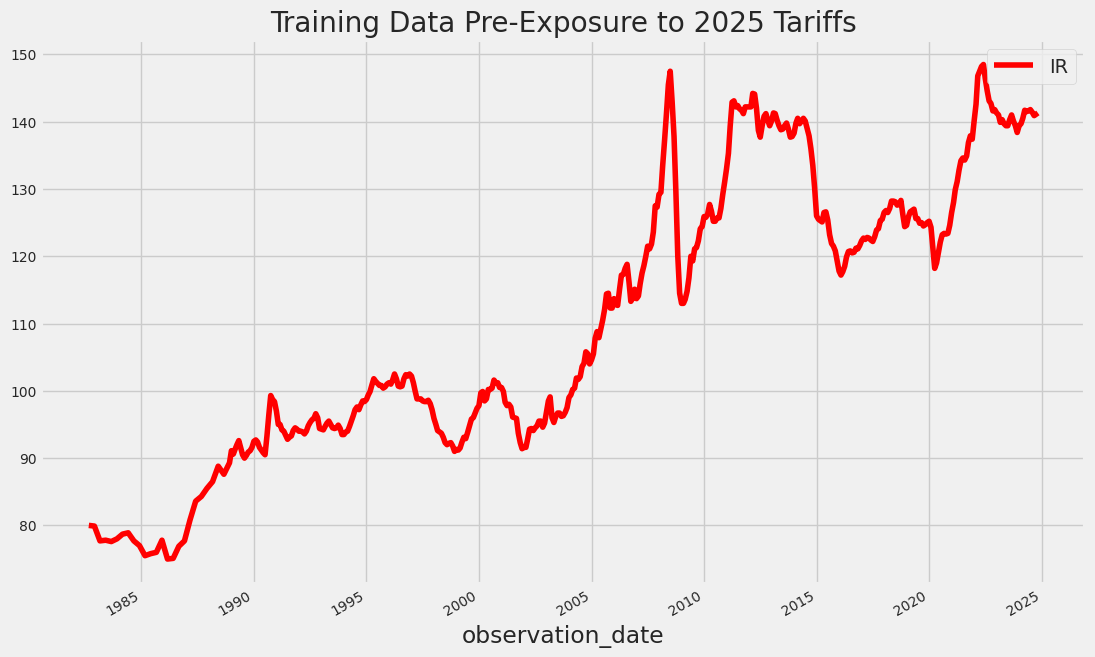

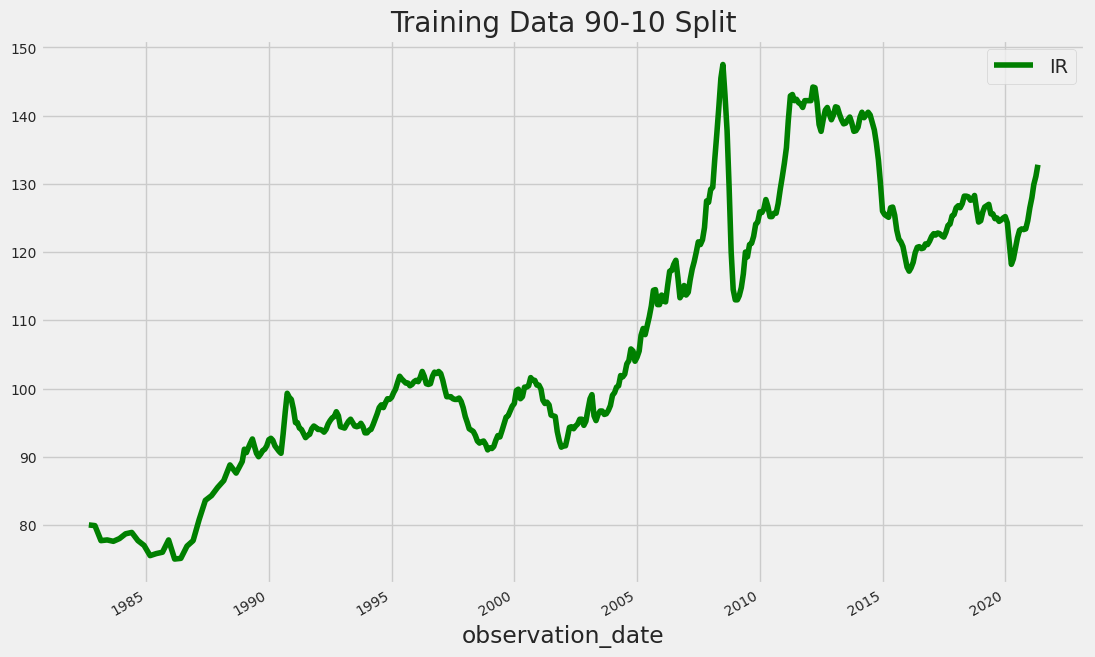

In [80]:
data = pd.read_excel("IR.xlsx")
data.head()
# Convert dates to datetime objects
data["observation_date"] = pd.to_datetime(data["observation_date"])
data = data.set_index("observation_date").asfreq("MS") #monthly freq
data.dropna(inplace=True)

split_date_df = "2025-09-01"
df_present = data.loc[data.index < split_date_df].copy() #current avail dates

#EDA
plt.figure(figsize=(10, 8))
sns.swarmplot(x="observation_date", y="IR", data=df_present, palette='viridis')
plt.title('Imports Price Index Over Time')
plt.xlabel('Date')
plt.ylabel('Import Price Index')
plt.show()
#

split_date_train1 = "2024-11-01" #training observations, pre-exposure to Trump
                                ## tariffs
split_date_train2 = "2021-05-01" #90-10 split
df_train1 = df_present.loc[df_present.index <= split_date_train1].copy()
df_test1 = df_present.loc[df_present.index > split_date_train1].copy()
df_train1.plot(figsize=(12, 8), color = "red", title= "Training Data Pre-Exposure to 2025 Tariffs")

df_train2 = df_present.loc[df_present.index <= split_date_train2].copy()
df_test2 = df_present.loc[df_present.index > split_date_train2].copy()
df_train2.plot(figsize=(12, 8), color = "green", title= "Training Data 90-10 Split")

[129.01253  129.45634  129.45634  129.2624   129.44095  129.25916
 128.6958   127.925835 127.95304  128.20958  128.84328  129.36601
 129.01253  129.45634  129.45634  129.2624   129.44095  129.25916
 128.6958   127.925835 127.95304  128.20958  128.84328  129.36601
 129.01253  129.45634  129.45634  129.2624   129.44095  129.25916
 128.6958   127.925835 127.95304  128.20958  128.84328  129.36601
 129.01253  129.45634  129.45634  129.2624   129.44095  129.25916
 128.6958   127.925835 127.95304  128.20958  128.84328  129.36601
 129.01253  129.45634  129.45634 ]
[129.2624   129.44095  129.25916  128.6958   127.925835 128.20958
 128.84328  129.36601  129.01253  129.45634  129.45634  129.2624
 129.44095  129.25916  128.6958  ]


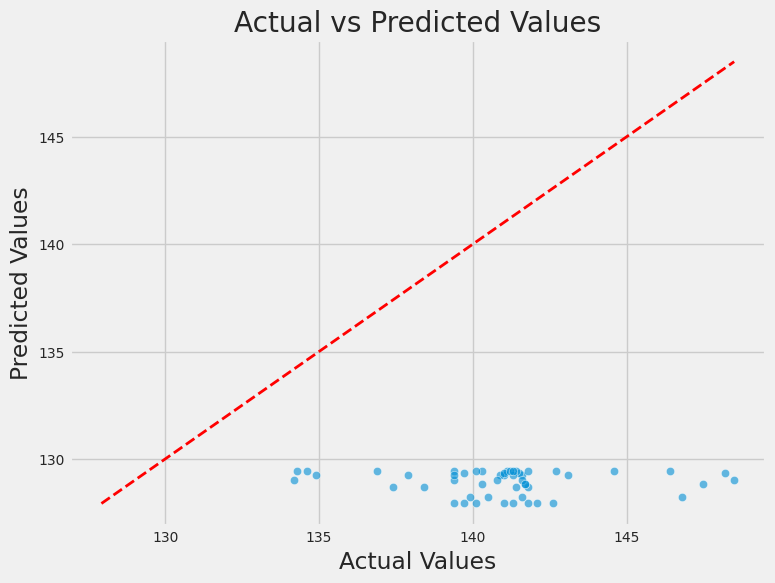

In [81]:
## k-cross validation
def add_lags(df):
    df['lag1'] = df['IR'].shift(1)
    df['lag2'] = df['IR'].shift(2)
    return df

def create_features(df_train2, label=None): #creating timeseries features
  df_train2["month"] = df_train2.index.month
  df_train2["year"] = df_train2.index.year

  #select features based on availability in the DataFrame
  selected_features = ["month", "year"]
  if "Ave_Tariff_Rate" in df_train2.columns:
    selected_features.append("Ave_Tariff_Rate")
  if "Imports(in_millions)" in df_train2.columns:
    selected_features.append("Imports(in_millions)")

  x = df_train2[selected_features]
  if label:
    y = df_train2[label]
    return x, y
  return x

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.6,
                'max_depth': 5, 'alpha': 6}

# creating features and labels for df_train
x_train_cv, y_train_cv = create_features(df_train2.copy(), label="IR")

# creating d-dimensional Matrix for cross-validation
dtrain_cv = xgb.DMatrix(data=x_train_cv, label=y_train_cv)

xgb_cv = cv(dtrain=dtrain_cv, params=params, nfold=5,
                  num_boost_round=500, early_stopping_rounds=20, metrics="rmse", as_pandas=True, seed=676)


model = xgb.XGBRegressor(**params)
model.fit(x_train_cv, y_train_cv)

# creating features for testing data
x_test_cv = create_features(df_test2.copy(), label="IR")[0]

y_pred_test = model.predict(x_test_cv)
print(y_pred_test)

#predicting future values
future_dates = data.loc[data.index >= split_date_df].copy()
future_dates = create_features(future_dates)
future_pred = model.predict(future_dates)
print(future_pred)
xgb_cv.head()


# scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_test2['IR'], y=y_pred_test, alpha=0.6)

# the ideal 'y=x' line (perfect predictions)
min_val = min(df_test2['IR'].min(), y_pred_test.min())
max_val = max(df_test2['IR'].max(), y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

[140.04434 139.4002  139.70436 140.49487 141.7049  141.50035 141.60031
 141.79523 141.40036]
1.756938334204673
[140.1434  139.41208 139.69633 140.46162 141.75189 141.49902 141.58588
 141.76184 141.40251]
1.7278004658170483
[140.94836 141.10243 141.28014 140.1434  139.41208 140.46162 141.75189
 141.49902 141.58588 141.76184 141.40251 140.94836 141.10243 141.28014
 140.1434 ]


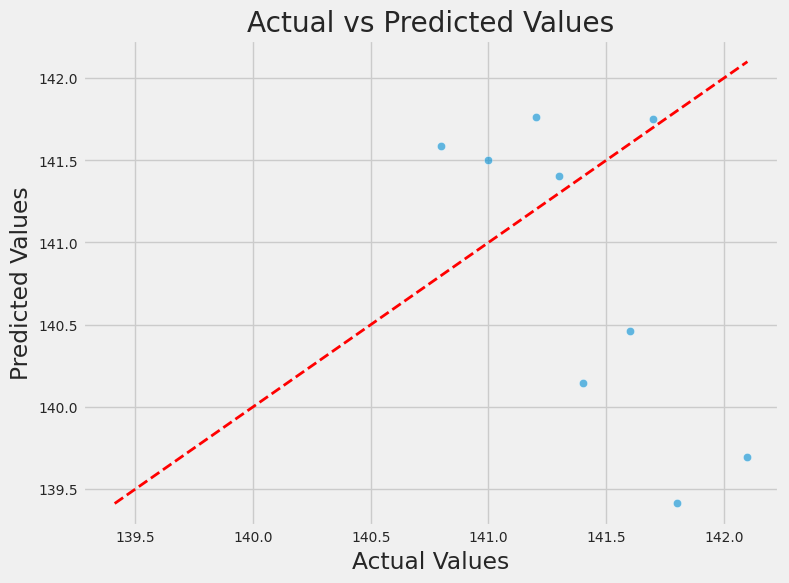

In [82]:
#XGBoost, test split at date prior to trump presidency
x_train, y_train = create_features(df_train1, label="IR")
x_test, y_test = create_features(df_test1, label="IR")

model = xgb.XGBRegressor(n_estimators = 1000)
model.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)],
          verbose = False)

y_pred = model.predict(x_test)
print(y_pred)
mse1 = mean_squared_error(y_test, y_pred)
print(mse1)


model = xgb.XGBRegressor(n_estimators = 500, max_depth = 4)
model.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)],
          verbose = False)

y_pred = model.predict(x_test)
print(y_pred)
mse2 = mean_squared_error(y_test, y_pred)
print(mse2)

future_dates = data.loc[data.index >= split_date_df].copy() #September 2025
future_dates.index
future_dates = create_features(future_dates)
future_pred = model.predict(future_dates)
print(future_pred)

# scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_test1['IR'], y=y_pred, alpha=0.6)

# ideal 'y=x' line (perfect predictions)
min_val = min(df_test1['IR'].min(), y_pred.min())
max_val = max(df_test1['IR'].max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)

plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

[Time Series with XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html) <br>
[K-fold Validation with XGBoost](https://www.kaggle.com/code/prashant111/xgboost-k-fold-cv-feature-importance)

<Axes: xlabel='date'>

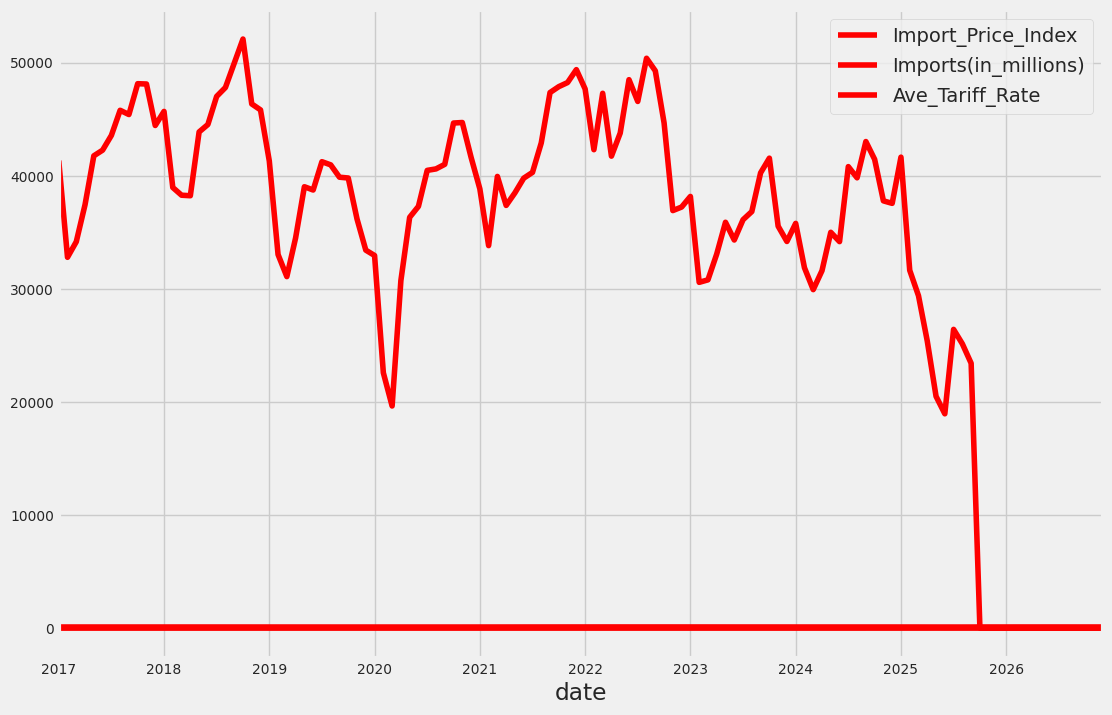

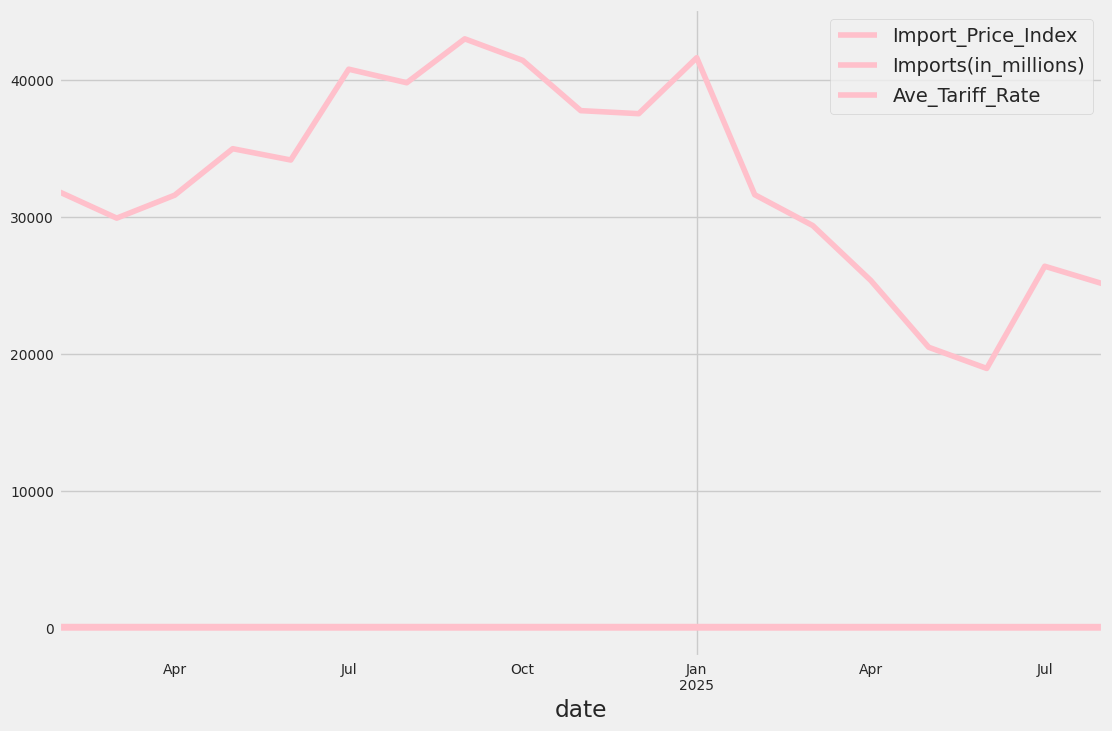

In [83]:
data_china = pd.read_excel("tarrifs_china.xlsx")
data_china.head()

data_china["date"] = pd.to_datetime(data_china["date"])
data_china = data_china.set_index("date").asfreq("MS") #monthly freq
data_china.dropna(inplace=True)
data_china.plot(figsize=(12, 8), color = "red")

split_date_china = "2025-09-01" #existing dates
df = data_china.loc[data_china.index < split_date_china].copy()
split_date_train_test = "2024-01-01"
df_train = df.loc[df.index <= split_date_train_test].copy()
df_test = df.loc[df.index > split_date_train_test].copy()
df_test.plot(figsize=(12, 8), color = "pink")

In [84]:
def create_features(df, label=None): #create timeseries features
  df["month"] = df.index.month
  df["year"] = df.index.year

  # Dynamically select features based on availability in the DataFrame
  selected_features = ["month", "year"]
  if "Ave_Tariff_Rate" in df.columns:
    selected_features.append("Ave_Tariff_Rate")
  if "Imports(in_millions)" in df.columns:
    selected_features.append("Imports(in_millions)")

  x = df[selected_features]
  if label:
    y = df[label]
    return x, y
  return x

# Re-create df_train and df_test specifically for the data_china context
split_date_china = "2025-09-01" #existing dates
df_china_present = data_china.loc[data_china.index < split_date_china].copy()
split_date_train_test_china = "2024-01-01"
df_train_china = df_china_present.loc[df_china_present.index <= split_date_train_test_china].copy()
df_test_china = df_china_present.loc[df_china_present.index > split_date_train_test_china].copy()

x_train, y_train = create_features(df_train_china, label="Import_Price_Index")
x_test, y_test = create_features(df_test_china, label="Import_Price_Index")


model = xgb.XGBRegressor(n_estimators = 1000, max_depth = 10)
model.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)],
          verbose = False)

y_pred = model.predict(x_test)
mse1_train = mean_squared_error(y_train, model.predict(x_train))
mse1_test = mean_squared_error(y_test, y_pred)
print(mse1_train, mse1_test)

model = xgb.XGBRegressor(n_estimators =30, max_depth=2)
model.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_test, y_test)],
          verbose = False)

y_pred = model.predict(x_test)
mse2_train = mean_squared_error(y_train, model.predict(x_train))
mse2_test = mean_squared_error(y_test, y_pred)
print(mse2_train, mse2_test)


future_dates = data_china.loc[data_china.index >= split_date_china].copy()
future_dates.index
future_dates = create_features(future_dates)
future_pred = model.predict(future_dates)
future_pred

print(future_pred)

9.024547522559319e-07 5.543577060212964
0.13729011135521021 5.430887587839538
[101.31631  101.43783  101.34619  101.16828  101.95977  101.8899
 101.8899   101.8899   101.8899   101.73402  101.526115 101.526115
 101.43783  101.43783  101.34619  101.16828 ]


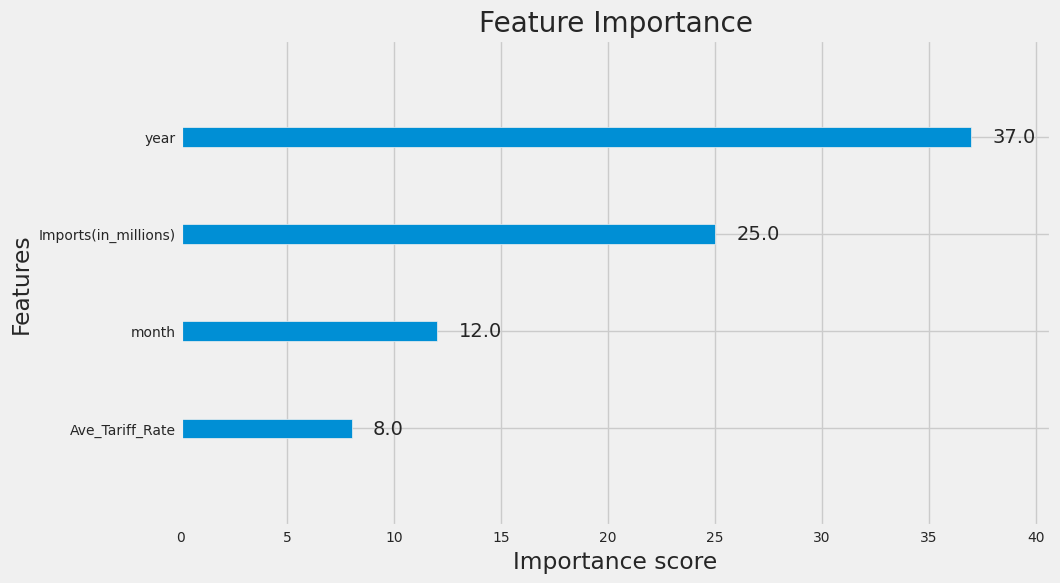

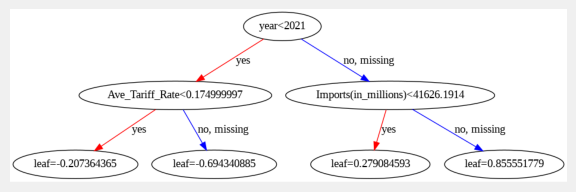

In [85]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, ax=plt.gca())
plt.title("Feature Importance")
plt.show()
plot_tree(model)
plt.show()

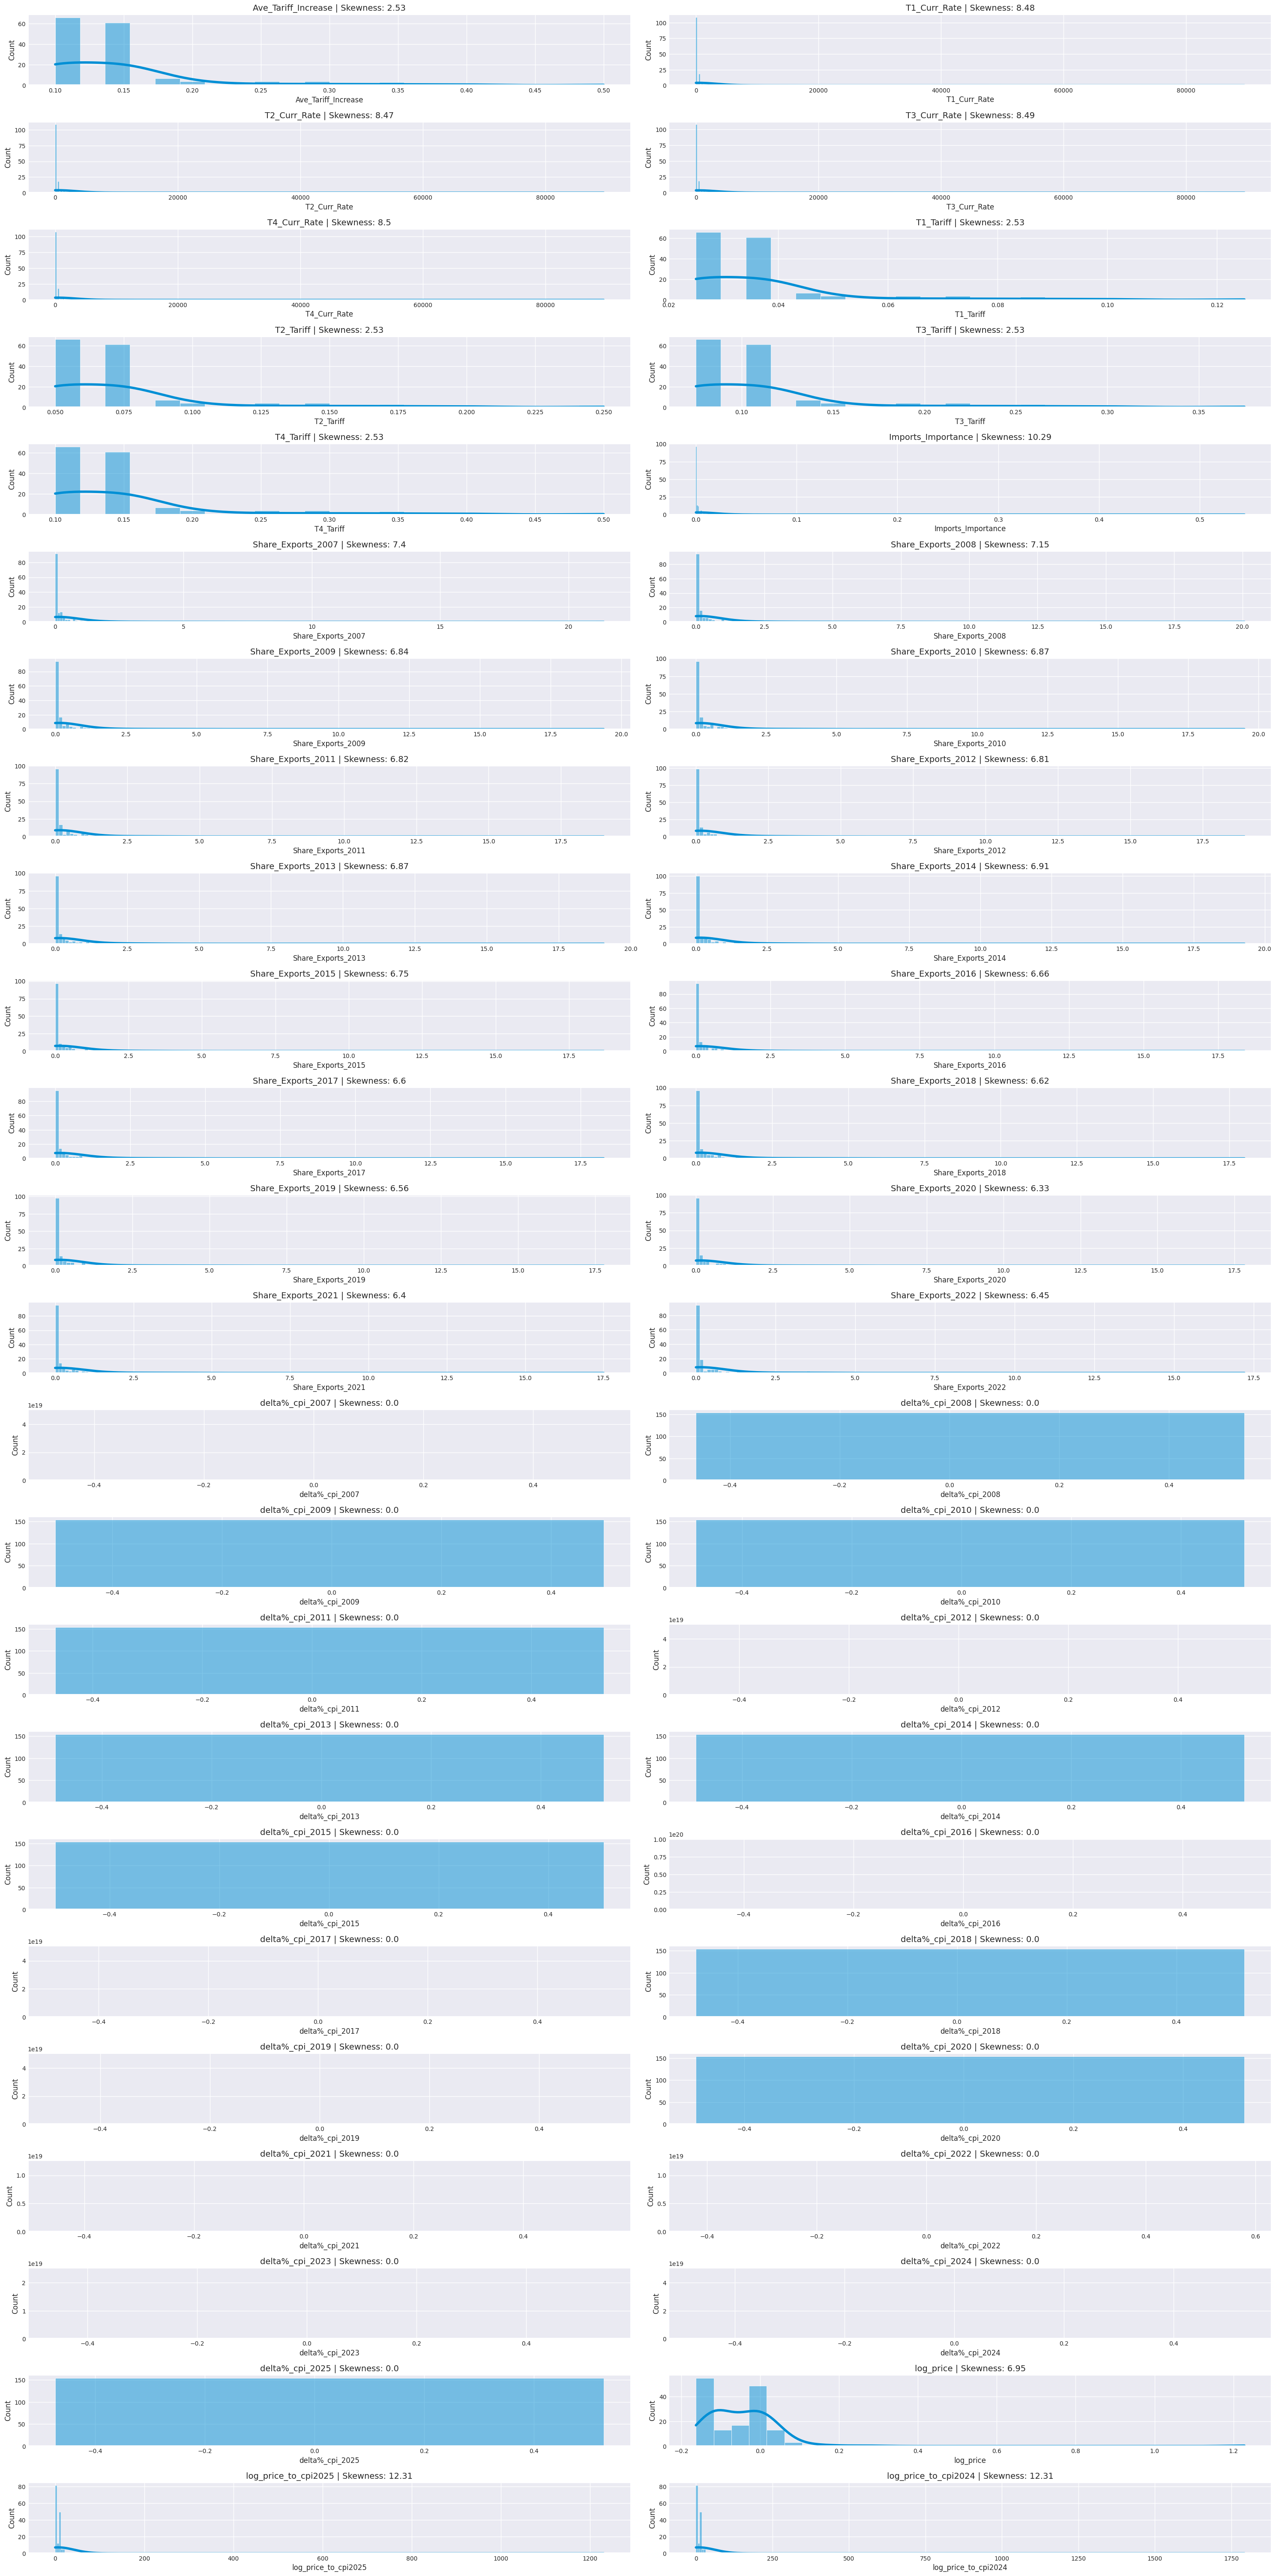

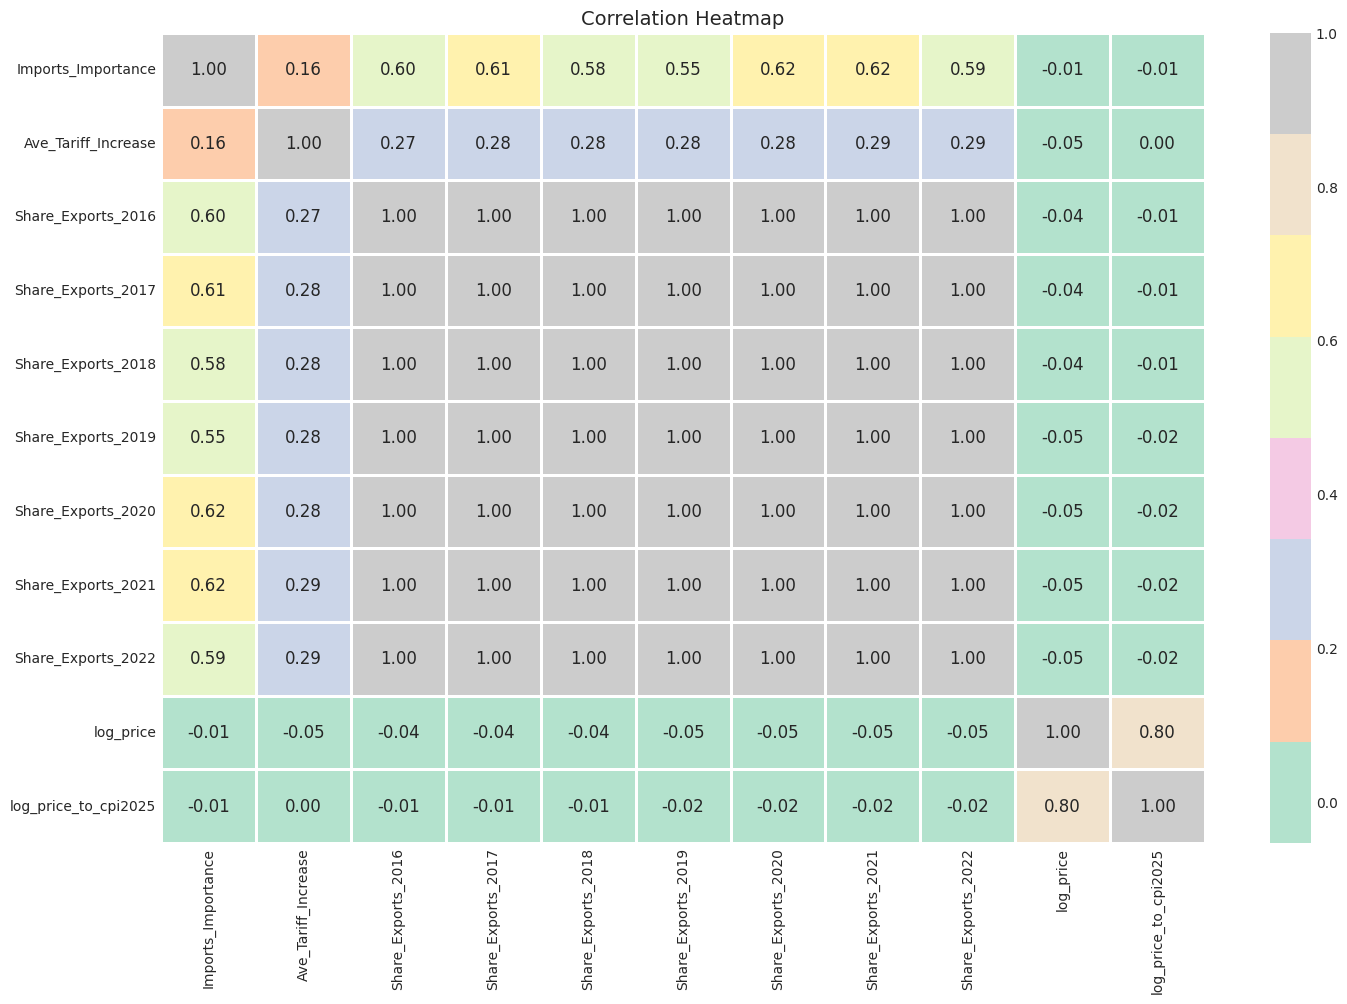

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


#variable for percent increase in exporting country's price of exports
# using currency conversion rates from beginning to end of yr
dataset = pd.read_excel("Tariffs_project_dataset.xlsx")

dataset.head()
US_inflation2025 = 0.035
US_inflation2024 = 0.029
#estimating base increase in import prices
dataset["log_price"] = np.log(dataset['T4_Curr_Rate']) - np.log(dataset['T1_Curr_Rate'])
dataset["log_price_to_cpi2025"] = pow(dataset["log_price"]/US_inflation2025, 2)
dataset["log_price_to_cpi2024"] = pow(dataset["log_price"]/US_inflation2024, 2)

dataset.drop(columns = ["Share_Exports_2007","Share_Exports_2008","Share_Exports_2009",
                   "Share_Exports_2010", "Share_Exports_2011", "Share_Exports_2012",
                    "Share_Exports_2013", "Share_Exports_2014", "Share_Exports_2015",
                    "delta%_cpi_2007", "delta%_cpi_2008", "delta%_cpi_2009",
                    "delta%_cpi_2010"])

features = ["Imports_Importance", "Ave_Tariff_Increase",
            "Share_Exports_2016",
            "Share_Exports_2017","Share_Exports_2018","Share_Exports_2019",
            "Share_Exports_2020","Share_Exports_2021","Share_Exports_2022",
            "log_price", "log_price_to_cpi2025",
            ]

dataset.describe().T
dataset.nunique()

sns.set_style("darkgrid")
numerical_columns = dataset.select_dtypes(include=["int64", "float64"]).columns

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.figure(figsize=(30, len(numerical_columns) * 2.5)) # Increased width and height multiplier
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(dataset[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(dataset[feature].skew(), 2)}", fontsize=14) # Set title fontsize
plt.tight_layout()
plt.show()

#correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(dataset[features].corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)
plt.title('Correlation Heatmap')
plt.show()


In [109]:
import statsmodels.formula.api as smf

formula = """
log_price ~ Ave_Tariff_Increase
           + Imports_Importance
           + Share_Exports_2022
           + Share_Exports_2021
           + Share_Exports_2020
"""

model = smf.ols(formula, data=dataset).fit(cov_type='HC3') # Changed data=df to data=dataset
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.027
Method:                 Least Squares   F-statistic:                    0.4247
Date:                Thu, 18 Dec 2025   Prob (F-statistic):              0.831
Time:                        01:22:19   Log-Likelihood:                 102.15
No. Observations:                 154   AIC:                            -192.3
Df Residuals:                     148   BIC:                            -174.1
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0301    

In [108]:
# Ppost = (1+t)Ppre
price_pass_through = {}

for i, tariff in enumerate(dataset["Ave_Tariff_Increase"]):
   price_pass_through[i] = 1 + tariff
print(price_pass_through)

percent_effect = {}
sum_percent_effect = 0
for i, importance in enumerate(dataset["Imports_Importance"]):
    percent_effect[i] =  importance*price_pass_through[i]
    sum_percent_effect += percent_effect[i]
print(percent_effect)
print(sum_percent_effect)

{0: 1.15, 1: 1.1, 2: 1.3, 3: 1.15, 4: 1.1, 5: 1.1, 6: 1.1, 7: 1.15, 8: 1.1, 9: 1.2, 10: 1.1, 11: 1.15, 12: 1.1, 13: 1.1, 14: 1.1, 15: 1.15, 16: 1.3, 17: 1.15, 18: 1.5, 19: 1.15, 20: 1.1, 21: 1.1, 22: 1.19, 23: 1.15, 24: 1.35, 25: 1.1, 26: 1.15, 27: 1.1, 28: 1.2, 29: 1.1, 30: 1.1, 31: 1.15, 32: 1.15, 33: 1.15, 34: 1.1, 35: 1.15, 36: 1.15, 37: 1.15, 38: 1.15, 39: 1.1, 40: 1.15, 41: 1.1, 42: 1.1, 43: 1.15, 44: 1.1, 45: 1.15, 46: 1.1, 47: 1.1, 48: 1.15, 49: 1.15, 50: 1.15, 51: 1.1, 52: 1.1, 53: 1.15, 54: 1.15, 55: 1.15, 56: 1.1, 57: 1.1, 58: 1.1, 59: 1.1, 60: 1.15, 61: 1.1, 62: 1.1, 63: 1.15, 64: 1.15, 65: 1.5, 66: 1.19, 67: 1.1, 68: 1.35, 69: 1.15, 70: 1.15, 71: 1.15, 72: 1.1, 73: 1.15, 74: 1.15, 75: 1.25, 76: 1.1, 77: 1.1, 78: 1.1, 79: 1.15, 80: 1.1, 81: 1.15, 82: 1.1, 83: 1.3, 84: 1.15, 85: 1.15, 86: 1.15, 87: 1.19, 88: 1.1, 89: 1.1, 90: 1.25, 91: 1.25, 92: 1.1, 93: 1.1, 94: 1.1, 95: 1.15, 96: 1.4, 97: 1.15, 98: 1.1, 99: 1.15, 100: 1.15, 101: 1.18, 102: 1.1, 103: 1.15, 104: 1.15, 105: 1